# Agenda


1.   Load dataset from HF hub
2.   Some EDA
3.   Tokenize data for DistilBERT
4.   Extract last hidden states from DistilBERT
5.   Train LogisticRegression classifier
6.   Fine-tune DistilBERT with own data & train model
7.   Error analysis
8.   Model use in practice




In [70]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score
from transformers import AutoTokenizer, DistilBertTokenizer, \
                         AutoModel, AutoModelForSequenceClassification, \
                         Trainer, TrainingArguments
from torch.nn.functional import cross_entropy


In [72]:
from datasets import list_datasets
from datasets import load_dataset

In [73]:
all_datasets = list_datasets()
print(len(all_datasets))

5188


In [74]:
all_datasets[:5]

['acronym_identification',
 'ade_corpus_v2',
 'adversarial_qa',
 'aeslc',
 'afrikaans_ner_corpus']

In [75]:
emotions = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [76]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [77]:
train_ds = emotions["train"]

In [79]:
train_ds[67]

{'label': 0,
 'text': 'i have been on a roller coaster of emotions over these supposed feelings that something unpleasant was coming'}

In [80]:
train_ds.column_names

['text', 'label']

In [81]:
train_ds.features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

In [82]:
labels = emotions["train"].features["label"].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [83]:
emotions["train"].features["label"].num_classes

6

In [13]:
train_ds[:5]

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

In [84]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [85]:
# helper function
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

In [87]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Some EDA

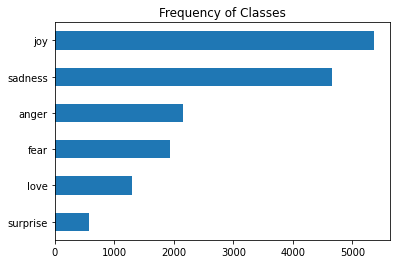

In [18]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


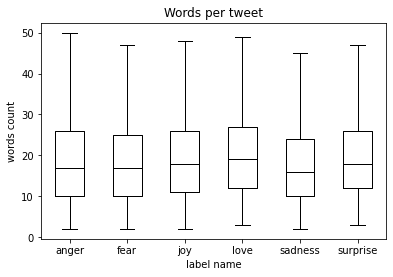

In [19]:
df["Words per tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("label name")
plt.ylabel("words count")
plt.show()

In [88]:
# remove pandas dataframe format
emotions.reset_format()

# Tokenize data

Tokenization is needed because BERT models' input is not raw strings but tokenized and encoded as numerical vectors.

In [21]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [22]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [89]:
text = "Sentence as an example."

In [90]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 6251, 2004, 2019, 2742, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [91]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]', 'sentence', 'as', 'an', 'example', '.', '[SEP]']

In [92]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] sentence as an example. [SEP]'

In [93]:
tokenizer.vocab_size, tokenizer.model_max_length, tokenizer.model_input_names

(30522, 512, ['input_ids', 'attention_mask'])

In [28]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [94]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [95]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].column_names

Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-3a9c55ebbd683fa4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-55738f0937c6f330.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-a3e8ac34c2a58a50.arrow


['text', 'label', 'input_ids', 'attention_mask']

In [96]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

# Extract the last hidden state

In [97]:
text

'Sentence as an example.'

In [98]:
inputs = tokenizer(text, return_tensors="pt")
inputs, inputs['input_ids'].size() 

({'input_ids': tensor([[ 101, 6251, 2004, 2019, 2742, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])},
 torch.Size([1, 7]))

*torch*.Size([1, 7]) - [batch_size, number_of_tokens]

In [34]:
# encodings as a tensor
inputs['input_ids']

tensor([[ 101, 6251, 2004, 2019, 2742, 1012,  102]])

In [99]:
# derive last hidden state
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
outputs

BaseModelOutput([('last_hidden_state',
                  tensor([[[-0.3701, -0.2720, -0.2445,  ..., -0.0752,  0.0055,  0.3905],
                           [ 0.0033, -0.0159, -0.2230,  ..., -0.0974,  0.2104, -0.3824],
                           [-0.2426,  0.0827, -0.1300,  ..., -0.0083,  0.0249,  0.2278],
                           ...,
                           [-0.5364,  0.3529, -0.5220,  ..., -0.3421, -0.1590, -0.0726],
                           [-0.6819, -0.7566, -0.4331,  ...,  0.3827,  0.2073, -0.1503],
                           [ 0.9874,  0.0497, -0.4902,  ...,  0.2408, -0.7476, -0.2267]]],
                         device='cuda:0'))])

In [100]:
# 768-dimensionality vector is returned for each of 7 tokens
outputs.last_hidden_state.size()

torch.Size([1, 7, 768])

In [101]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [102]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [103]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

# Training simple classifier

In [40]:
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [41]:
# takes time to run this cell!!

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
lr.score(X_valid, y_valid)

0.6335

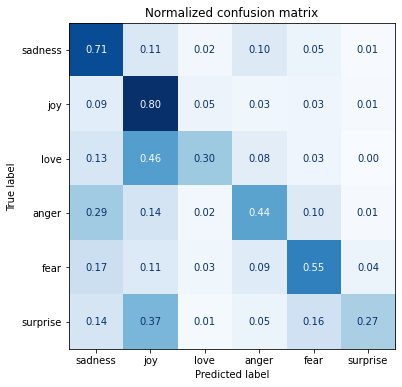

In [42]:
def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)


# Fine-tuning transformers

In [104]:
model_ckpt, labels

('distilbert-base-uncased',
 ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [105]:
# loading pretrained model

num_labels = len(labels)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)

In [106]:
num_labels

6

In [107]:
# define performance metrics

def compute_metrics(pred):
  label_prediction = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(label_prediction, preds, average="weighted")
  acc = accuracy_score(label_prediction, preds)
  return {"accuracy": acc, 
          "f1": f1
          }

In [108]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


# Prepare Trainer 

In [109]:
batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion-tweets"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)


In [110]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.290464,0.915000,0.913569
2,No log,0.214053,0.923000,0.923204


TrainOutput(global_step=500, training_loss=0.5193793334960938, metrics={'train_runtime': 237.9139, 'train_samples_per_second': 134.502, 'train_steps_per_second': 2.102, 'total_flos': 720342861696000.0, 'train_loss': 0.5193793334960938, 'epoch': 2.0})

In [111]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_accuracy': 0.923,
 'test_f1': 0.9232037822606469,
 'test_loss': 0.21405263245105743,
 'test_runtime': 4.5257,
 'test_samples_per_second': 441.917,
 'test_steps_per_second': 7.071}

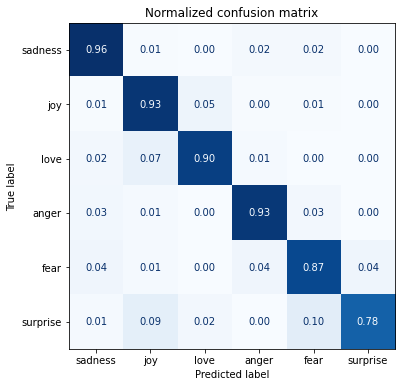

In [112]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

Error analysis

In [58]:
def forward_pass_with_label(batch):
  input = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [59]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=1
)

  0%|          | 0/2000 [00:00<?, ?ba/s]

In [60]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [61]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1808,i could feel the depth and richness of the hot...,love,joy,3.861804
270,i feel that anger toward someone else not cari...,love,joy,3.861804
441,i was feeling a bit nostalgic and typed all th...,love,joy,3.861804
1419,i feel at this point i have to give some credi...,love,joy,3.861804
1035,i feel like im supporting a community that i l...,love,joy,3.861804
425,i still can t shake the feeling of him loving ...,love,joy,3.861804
1058,im over having this feeling of doubt because i...,love,joy,3.861804
123,i ahem guess i havent been feeling compassionate,love,joy,3.861804
1061,i just need to swear off feelings caring relat...,love,joy,3.861804
1065,i know have no problem meeting new people and ...,love,joy,3.861804


In [62]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1999,i feel like i just wanna buy any cute make up ...,joy,joy,1.028078
1425,i see you the light in the room brightens i ge...,joy,joy,1.028078
640,i feel like i havent blogged in a super long time,joy,joy,1.028078
1424,i feel strongly about amused,joy,joy,1.028078
1423,i feel so privileged to have spent so much tim...,joy,joy,1.028078
644,i have a feeling a forks version of that charm...,joy,joy,1.028078
646,i wear funny cartoon t shirts of course with m...,joy,joy,1.028078
648,i feel it is vital to lay everything on the ta...,joy,joy,1.028078
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,1.028078
651,i am feeling fine i guess,joy,joy,1.028078


In [113]:
model_name = 'Yuliya-HV/distilbert-base-uncased-finetuned-emotion-tweets'

from transformers import pipeline
classifier = pipeline("text-classification", model=model_name)


In [118]:
example = "I love nature"
prediction = classifier(example, return_all_scores=True)

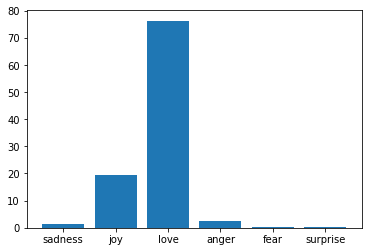

In [119]:
df_preds =pd.DataFrame(prediction[0])
plt.bar(labels, 100*df_preds["score"])
plt.show()